In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from sklearn.cluster import KMeans
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

"""
First we will import the necessary libraries for our analysis.
We might also need some functions from our main.py file
"""
import main


c:\Users\steph\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\steph\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\steph\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framewo

In [2]:
# Let's first get the datasets and split them
joke_dataset, train_dataset_full, train_dataset, val_dataset, test_dataset = main.load_and_split_data()

# This will split the dataset up into training and test sets and create the necessary input/output pairs
selected_indices, complement_indices, JTrain_x, JTrain_y, JTest_x, JTest_y = main.select_train_complement_indices(
        joke_dataset, train_dataset_full, train_dataset, val_dataset, test_dataset, cross_validation=True)




Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.3601 - mae: 0.5122 - val_loss: 0.3062 - val_mae: 0.4698
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3479 - mae: 0.5024 - val_loss: 0.2843 - val_mae: 0.4504
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3043 - mae: 0.4643 - val_loss: 0.2641 - val_mae: 0.4321
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3022 - mae: 0.4654 - val_loss: 0.2448 - val_mae: 0.4136
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2640 - mae: 0.4345 - val_loss: 0.2272 - val_mae: 0.3963
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2583 - mae: 0.4229 - val_loss: 0.2107 - val_mae: 0.3803
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2309 - mae: 0.3982 - val_loss: 0.1952 - val_mae: 0.3642
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2199 - mae: 0.3912 - val_loss: 0.1807 - val_mae: 0.3496
Epoch 9/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2111 - mae: 0.3804 - 

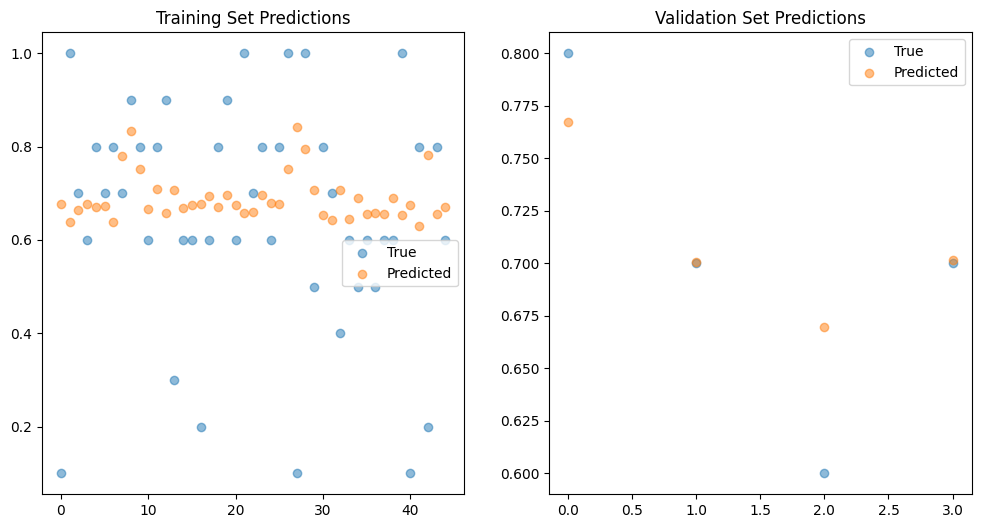

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
predictive dev set:[0.76715535 0.70075226 0.66943324 0.7016335 ]
actual dev set:[0.8 0.7 0.6 0.7]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
sample predictive train set:[0.6765588  0.63764364 0.66499245 0.6780117  0.6706297  0.6733003
 0.63749677 0.7792199  0.83239675 0.752978   0.66540337 0.7099642
 0.6570824  0.70615166 0.6693979  0.67475116 0.67599225 0.6939273
 0.67165685 0.6972735  0.6741208  0.65766555 0.65893036 0.6961197
 0.67929155 0.6778766  0.752314   0.84154195 0.7955313  0.70664215
 0.65396976 0.64319736 0.70707977 0.64544976 0.6902948  0.6551279
 0.6572221  0.6554391  0.6890923  0.6541893  0.67425364 0.63078415
 0.7820757  0.65452695 0.67150384]
sample actual train set:[0.1 1.  0.7 0.6 0.8 0.7 0.8 0.7 0.9 0.8 0.6 0.8 0.9 0.3 0.6 0.6 0.2 0.6
 0.8 0.9 0.6 1.  0.7 0.8 0.6 0.8 1.  0.1 1.  0.5 0.8 0.7 0.4 0.6 0.5 0.6
 0.5 0.6 0.6 1.  0.1 0.8 0.2 0.8 0.6]


In [3]:
# Now let's create a cross-validation routine

import time

def cross_validate_model(data, selected_indices, complement_indices, k=2, n_splits=5, plot=True):
    """
    Perform k-fold cross-validation on the dataset.
    
    Parameters:
    data (numpy.ndarray): Full dataset.
    selected_indices (list): Indices of selected features.
    complement_indices (list): Indices of complementary features.
    k (int): Number of components for dimensionality reduction.
    n_splits (int): Number of folds for cross-validation.
    
    Returns:
    avg_model (numpy.ndarray): Averaged model parameters across all folds.
    avg_train_error (float): Average relative error on training sets across all folds.
    avg_val_error (float): Average relative error on validation sets across all folds.
    avg_loss_training (float): Average loss on training sets across all folds.
    avg_loss_validation (float): Average loss on validation sets across all folds.
    """

    k = 2

    normalization_factor = 1/10 
    data = data * normalization_factor # Normalize the data to be between 0 and 1

    kfold = KFold(n_splits=n_splits)

    all_relative_errors_training = []
    all_relative_errors_validation = []
    all_loss_training = []
    all_loss_validation = []
    all_models = []

    for train_index, val_index in kfold.split(data):



        X_train, X_val = data[train_index], data[val_index]
        JTrain_x = X_train[:, selected_indices]
        JTrain_y = X_train[:, complement_indices]
        JDev_x = X_val[:, selected_indices]
        JDev_y = X_val[:, complement_indices]

        mu_x = np.mean(JTrain_x, axis=0)
        X_train_centered = JTrain_x - mu_x
        X_val_centered = JDev_x - mu_x


        U, S, V_T = np.linalg.svd(JTrain_x, full_matrices=False)
        U_k = U[:, :k]
        S_k = np.diag(S[:k])
        V_T_k = V_T[:k, :]

        xtrain_reduced = X_train_centered @ V_T_k.T
        xtrain_reduced = np.hstack((xtrain_reduced, np.ones((xtrain_reduced.shape[0], 1))))  # Add bias term
        x_dev_reduced = X_val_centered @ V_T_k.T
        x_dev_reduced = np.hstack((x_dev_reduced, np.ones((x_dev_reduced.shape[0], 1))))  # Add bias term

        model = keras.Sequential([
            keras.layers.Input(shape=(xtrain_reduced.shape[1],)),
            keras.layers.Dense(16, activation="relu"), #kernel_regularizer=keras.regularizers.l2(1e-3)), #what does this do?
            keras.layers.Dense(JTrain_y.shape[1], activation="linear")
        ])

        model.compile(optimizer="adam",
                       loss="mse", metrics=["mae"])


        model.fit(
            xtrain_reduced, JTrain_y,
            validation_data=(x_dev_reduced, JDev_y),
            epochs=30,
            batch_size=8,   # smaller batch size helps with tiny datasets
            callbacks=[EarlyStopping(patience=10, restore_best_weights=True)]
        )


        # time_start = time.time()
        # model.fit(xtrain_reduced, JTrain_y, epochs=5, batch_size=32)
        # time_end = time.time()
        # print(f"Training time: {time_end - time_start} seconds")

        all_models.append(model)
        print(f'train rel error: {np.linalg.norm(model.predict(xtrain_reduced) - JTrain_y, "fro") / np.linalg.norm(JTrain_y, "fro")}')
        all_relative_errors_training.append(np.linalg.norm(model.predict(xtrain_reduced) - JTrain_y, "fro") / np.linalg.norm(JTrain_y, "fro"))
        all_relative_errors_validation.append(np.linalg.norm(model.predict(x_dev_reduced) - JDev_y, "fro") / np.linalg.norm(JDev_y, "fro"))
        print(f'val rel error: {np.linalg.norm(model.predict(x_dev_reduced) - JDev_y, "fro") / np.linalg.norm(JDev_y, "fro")}')
        all_loss_training.append(np.mean(model.evaluate(xtrain_reduced, JTrain_y)))
        all_loss_validation.append(np.mean(model.evaluate(x_dev_reduced, JDev_y)))

        dev_predictions = model.predict(x_dev_reduced)
        dev_residuals = dev_predictions - JDev_y
        train_predictions = model.predict(xtrain_reduced)
        train_residuals = train_predictions - JTrain_y
        print(f'train residuals: {np.linalg.norm(train_residuals, "fro") / np.linalg.norm(JTrain_y, "fro")}')
        print(f'dev residuals: {np.linalg.norm(dev_residuals, "fro") / np.linalg.norm(JDev_y, "fro")}')
        print('\n')


    #create a plot of a random in the training set
    
    random_index = np.random.randint(0, 26)
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Training Set Predictions")
    plt.scatter(np.arange(0, len(JTrain_y)), JTrain_y[:, random_index], label="True", alpha=0.5)
    plt.scatter(np.arange(0, len(JTrain_y)), model.predict(xtrain_reduced)[:, random_index], label="Predicted", alpha=0.5)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title("Validation Set Predictions")
    plt.scatter(np.arange(len(JDev_y)), JDev_y[:, random_index], label="True", alpha=0.5)
    plt.scatter(np.arange(len(JDev_y)), model.predict(x_dev_reduced)[:, random_index], label="Predicted", alpha=0.5)
    plt.legend()

    plt.show()

    #avg_model = np.mean(all_models, axis=0)  # Averaging models might not be the best idea in either NN or Linear model since the model could be converging to two different local minima in the objective function space
    avg_train_error = np.mean(all_relative_errors_training)
    avg_val_error = np.mean(all_relative_errors_validation)
    avg_loss_training = np.mean(all_loss_training)
    avg_loss_validation = np.mean(all_loss_validation)

    print(f'predictive dev set:{model.predict(x_dev_reduced)[:, random_index]}')
    print(f'actual dev set:{JDev_y[:, random_index]}')

    print(f'sample predictive train set:{model.predict(xtrain_reduced)[:, random_index]}')
    print(f'sample actual train set:{JTrain_y[:, random_index]}')

    return all_models, all_relative_errors_training, all_relative_errors_validation, all_loss_training, all_loss_validation, avg_train_error, avg_val_error, avg_loss_training, avg_loss_validation

######################
    all_relative_errors_training = []
    all_relative_errors_validation = []
    all_models = []

    for train_index, val_index in kfold.split(data):
        X_train, X_val = data[train_index], data[val_index]

        JTrain_x = X_train[:, selected_indices]
        JTrain_y = X_train[:, complement_indices]
        JDev_x = X_val[:, selected_indices]
        JDev_y = X_val[:, complement_indices]

        model = train_model(JTrain_x, JTrain_y, k)
        train_relative_error = evaluate_model(model, JTrain_x, JTrain_y)
        val_relative_error = evaluate_model(model, JDev_x, JDev_y)

        all_models.append(model)
        all_relative_errors_training.append(train_relative_error)
        all_relative_errors_validation.append(val_relative_error)

    avg_model = np.mean(all_models, axis=0)  # Average model coefficients
    avg_train_error = np.mean(all_relative_errors_training)
    avg_val_error = np.mean(all_relative_errors_validation)

    return avg_model, avg_train_error, avg_val_error

# Now we can run the cross-validation routine first with n_splits=10
all_models, all_relative_errors_training, all_relative_errors_validation, all_loss_training, all_loss_validation, avg_train_error, avg_val_error, avg_loss_training, avg_loss_validation = cross_validate_model(train_dataset_full, selected_indices, complement_indices, n_splits=10)


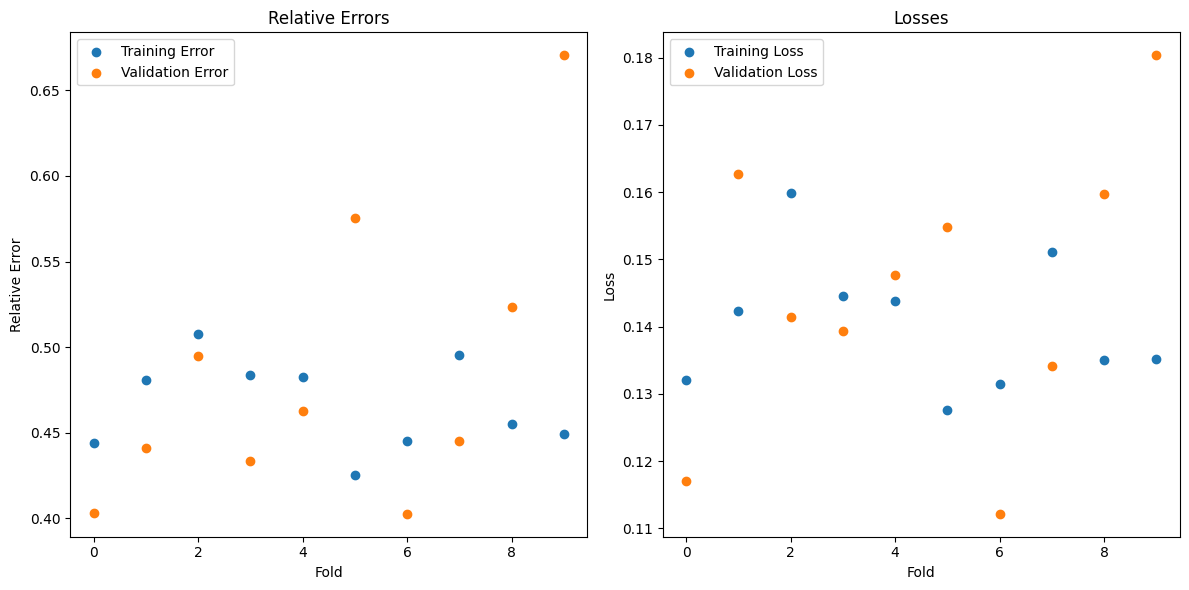

[[2.]
 [2.]
 [2.]]


In [4]:
# Let's plot some results

import matplotlib.pyplot as plt

fold_number = np.arange(0, len(all_relative_errors_training))
# Plot training and validation errors
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(fold_number, all_relative_errors_training, label='Training Error')
plt.scatter(fold_number, all_relative_errors_validation, label='Validation Error')
plt.title('Relative Errors')
plt.xlabel('Fold')
plt.ylabel('Relative Error')
plt.legend()

# Plot training and validation losses
plt.subplot(1, 2, 2)
plt.scatter(fold_number, all_loss_training, label='Training Loss')
plt.scatter(fold_number, all_loss_validation, label='Validation Loss')
plt.title('Losses')
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

print(np.ones((3, 1))*2)

In [5]:
# modify the cross-validation routine for a grid search:

def cross_validate_model(data, selected_indices, complement_indices, n_deep_layers, nodes_per_layer=16, k=2, batch_size=8, num_epochs=30, n_splits=5):
    """
    Perform k-fold cross-validation on the dataset.
    
    Parameters:
    data (numpy.ndarray): Full dataset.
    selected_indices (list): Indices of selected features.
    complement_indices (list): Indices of complementary features.
    k (int): Number of components for dimensionality reduction.
    n_splits (int): Number of folds for cross-validation.
    
    Returns:
    avg_model (numpy.ndarray): Averaged model parameters across all folds.
    avg_train_error (float): Average relative error on training sets across all folds.
    avg_val_error (float): Average relative error on validation sets across all folds.
    avg_loss_training (float): Average loss on training sets across all folds.
    avg_loss_validation (float): Average loss on validation sets across all folds.
    """

    

    normalization_factor = 1/10 
    data = data * normalization_factor # Normalize the data to be between 0 and 1

    kfold = KFold(n_splits=n_splits)

    all_relative_errors_training = []
    all_relative_errors_validation = []
    all_loss_training = []
    all_loss_validation = []
    all_models = []

    for train_index, val_index in kfold.split(data):

        X_train, X_val = data[train_index], data[val_index]
        JTrain_x = X_train[:, selected_indices]
        JTrain_y = X_train[:, complement_indices]
        JDev_x = X_val[:, selected_indices]
        JDev_y = X_val[:, complement_indices]

        mu_x = np.mean(JTrain_x, axis=0)
        X_train_centered = JTrain_x - mu_x
        X_val_centered = JDev_x - mu_x


        U, S, V_T = np.linalg.svd(JTrain_x, full_matrices=False)
        U_k = U[:, :k]
        S_k = np.diag(S[:k])
        V_T_k = V_T[:k, :]

        xtrain_reduced = X_train_centered @ V_T_k.T
        xtrain_reduced = np.hstack((xtrain_reduced, np.ones((xtrain_reduced.shape[0], 1))))  # Add bias term
        x_dev_reduced = X_val_centered @ V_T_k.T
        x_dev_reduced = np.hstack((x_dev_reduced, np.ones((x_dev_reduced.shape[0], 1))))  # Add bias term

        layers = [keras.layers.Input(shape=(xtrain_reduced.shape[1],))]
        for i in range(n_deep_layers):
            layers.append(keras.layers.Dense(nodes_per_layer, activation="relu"))
        layers.append(keras.layers.Dense(JTrain_y.shape[1], activation="linear"))
        model = keras.Sequential(layers)
        model.compile(optimizer="adam",
                       loss="mse", metrics=["mae"])


        model.fit(
            xtrain_reduced, JTrain_y,
            #validation_data=(x_dev_reduced, JDev_y),
            epochs=num_epochs,
            batch_size=batch_size,   # smaller batch size helps with tiny datasets
            #callbacks=[EarlyStopping(patience=10, restore_best_weights=True)]
        )



        all_models.append(model)
        all_relative_errors_training.append(np.linalg.norm(model.predict(xtrain_reduced) - JTrain_y, "fro") / np.linalg.norm(JTrain_y, "fro"))
        all_relative_errors_validation.append(np.linalg.norm(model.predict(x_dev_reduced) - JDev_y, "fro") / np.linalg.norm(JDev_y, "fro"))
        all_loss_training.append(np.mean(model.evaluate(xtrain_reduced, JTrain_y)))
        all_loss_validation.append(np.mean(model.evaluate(x_dev_reduced, JDev_y)))

        dev_predictions = model.predict(x_dev_reduced)
        dev_residuals = dev_predictions - JDev_y
        train_predictions = model.predict(xtrain_reduced)
        train_residuals = train_predictions - JTrain_y



    #avg_model = np.mean(all_models, axis=0)  # Averaging models might not be the best idea in either NN or Linear model since the model could be converging to two different local minima in the objective function space
    avg_train_error = np.mean(all_relative_errors_training)
    avg_val_error = np.mean(all_relative_errors_validation)
    avg_loss_training = np.mean(all_loss_training)
    avg_loss_validation = np.mean(all_loss_validation)


    return all_models, all_relative_errors_training, all_relative_errors_validation, all_loss_training, all_loss_validation, avg_train_error, avg_val_error, avg_loss_training, avg_loss_validation

## Hyperparameter Tuning: gridsearch method

def my_gridsearch(data, selected_indices, complement_indices, n_deep_layers, nodes_per_layer_options, k_options, batch_size_options, num_epochs_options, n_splits=5):

    best_model = None
    best_val_error = float("inf")
    all_results = []
    for n_deep_layer in n_deep_layers:
        for nodes_per_layer in nodes_per_layer_options:
            for k in k_options:
                for batch_size in batch_size_options:
                    for num_epochs in num_epochs_options:

                        print(f"Training with n_deep_layers={n_deep_layer}, nodes_per_layer={nodes_per_layer}, k={k}, batch_size={batch_size}, num_epochs={num_epochs}")

                        models, rel_errors_train, rel_errors_val, loss_train, loss_val, avg_train_error, avg_val_error, avg_loss_train, avg_loss_val = cross_validate_model(
                            data, selected_indices, complement_indices, n_deep_layer, nodes_per_layer=nodes_per_layer, k=k, batch_size=batch_size, num_epochs=num_epochs, n_splits=n_splits
                        )

                        all_results.append({
                            "n_deep_layers": n_deep_layer,
                            "nodes_per_layer": nodes_per_layer,
                            "k": k,
                            "batch_size": batch_size,
                            "num_epochs": num_epochs,
                            "avg_val_error": avg_val_error
                        })

                        if avg_val_error < best_val_error:
                            best_val_error = avg_val_error
                            best_model = models

    return best_model, all_results

# perform grid search
data = train_dataset_full
n_deep_layers = [0, 1, 2]
best_model, all_results = my_gridsearch(
    data, selected_indices, complement_indices, n_deep_layers,
    nodes_per_layer_options=[8],
    k_options=[1, 2, 3, 4, 8],
    batch_size_options=[2, 8, 16],
    num_epochs_options=[5, 20, 50],
    n_splits=5
)

#save results
pd.DataFrame(all_results).to_csv("grid_search_results.csv", index=False)
pd.DataFrame(best_model).to_csv("best_model.csv", index=False)

Training with n_deep_layers=0, nodes_per_layer=8, k=1, batch_size=2, num_epochs=5
Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5452 - mae: 0.6398  
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4769 - mae: 0.5946 
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4471 - mae: 0.5622 
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3919 - mae: 0.5291 
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3801 - mae: 0.5115 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3522 - mae: 0.4963
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.4184 - mae: 0.5457
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4551 - mae: 0.5776  
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3728 - mae: 0.5179 
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4031 - mae: 0.5370

KeyboardInterrupt: 

minimum error:0.4242199305673039 
 with parameters: n_deep_layers       2.00000
nodes_per_layer     8.00000
k                   4.00000
batch_size          2.00000
num_epochs         50.00000
avg_val_error       0.42422
Name: 119, dtype: float64


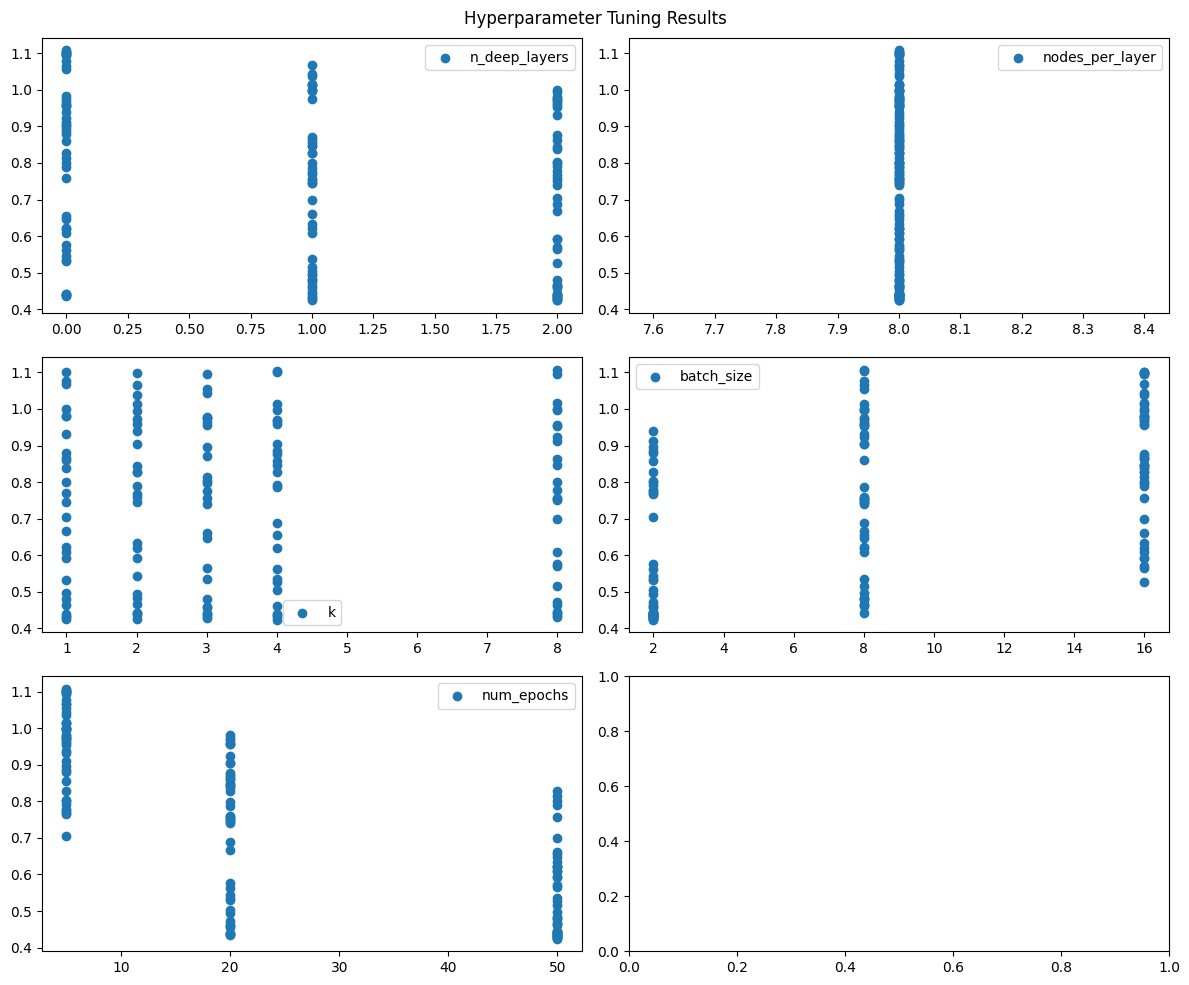

In [ ]:
# scatter plot for each variable
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))
axs = axs.flatten()
df = pd.DataFrame(all_results)

#search for the minimum
min_val_error = df['avg_val_error'].min()
best_params = df[df['avg_val_error'] == min_val_error].iloc[0]
print(f'minimum error:{min_val_error} \n with parameters: {best_params}')

# for i, col in enumerate(['avg_train_error', 'avg_val_error', 'avg_loss_train', 'avg_loss_val']):
#     df.scatter(column=col, by=['n_deep_layers', 'nodes_per_layer', 'k', 'batch_size', 'num_epochs'], ax=axs[i])
#     axs[i].set_title(col)
#     axs[i].set_xlabel("Hyperparameters")
#     axs[i].set_ylabel("Value")

for i in range(df.shape[1]-1):
    axs[i].scatter(df.iloc[:, i], df['avg_val_error'], label=df.columns[i])
    axs[i].legend([df.columns[i]])

plt.suptitle("Hyperparameter Tuning Results")
plt.tight_layout()
plt.show()


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3023 - mae: 0.4708  
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2765 - mae: 0.4471 
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3004 - mae: 0.4719 
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2765 - mae: 0.4412 
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2690 - mae: 0.4439 
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2501 - mae: 0.4216 
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2669 - mae: 0.4373 
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2649 - mae: 0.4369 
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2128 - mae: 0.3844 
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2380 - mae: 0.4121 
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2055 - mae: 0.3749 
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2057 - mae: 0.3780 
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2

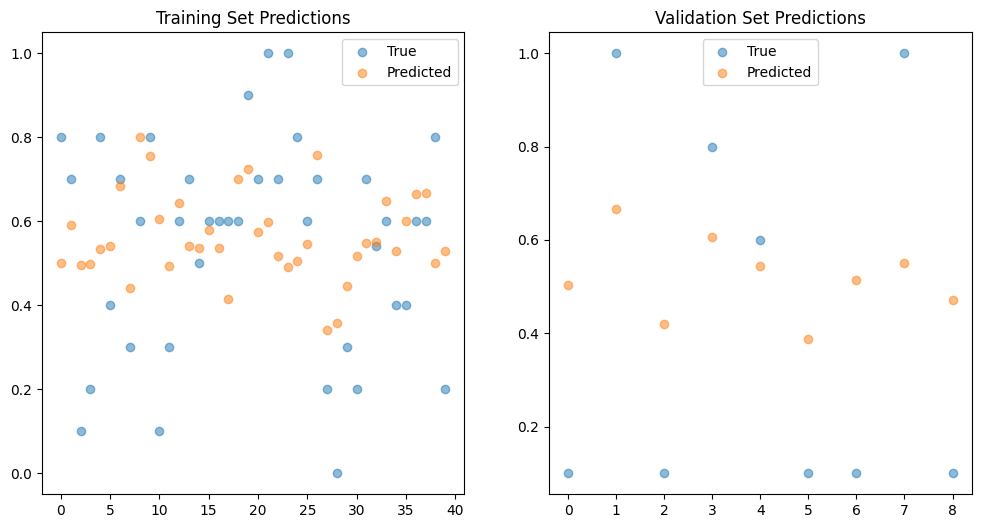

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
predictive dev set:[0.50320566 0.6668806  0.42059845 0.6068361  0.5436877  0.3885864
 0.5150942  0.55160385 0.4707856 ]
actual dev set:[0.1 1.  0.1 0.8 0.6 0.1 0.1 1.  0.1]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
sample predictive train set:[0.5015702  0.5909673  0.494877   0.4973812  0.5333561  0.5410285
 0.68362296 0.44214877 0.800823   0.75484204 0.60425204 0.49435937
 0.64423823 0.5413755  0.5355115  0.5785551  0.5368222  0.4148933
 0.70054674 0.72548866 0.57494485 0.59867156 0.5175656  0.49227518
 0.5043299  0.54692847 0.75860286 0.3410958  0.35838008 0.44677016
 0.51837134 0.5487963  0.55103654 0.6477519  0.5289537  0.5999286
 0.6653966  0.6678971  0.5012144  0.5286457 ]
sample actual train set:[0.8     0.7     0.1     0.2     0.8     0.4     0.7     0.3     0.6
 0.8     0.1     0.3     0.6     0.7     0.5     0.6     0.6     0.6
 0.6     0.9     0.7     1.      0.7     1.      0.8     0.6     0.7
 0.2     0.      0.3     0.2     0.7     0.5419

([<Sequential name=sequential_767, built=True>,
  <Sequential name=sequential_768, built=True>,
  <Sequential name=sequential_769, built=True>,
  <Sequential name=sequential_770, built=True>,
  <Sequential name=sequential_771, built=True>],
 [np.float64(0.435860049834171),
  np.float64(0.42766349803206616),
  np.float64(0.4017879246557342),
  np.float64(0.49217320286193605),
  np.float64(0.4202890385690654)],
 [np.float64(0.3872308629546252),
  np.float64(0.41213313245518324),
  np.float64(0.4665131186863941),
  np.float64(0.4381086119528246),
  np.float64(0.597022809780138)],
 [np.float64(0.1256096176803112),
  np.float64(0.12425710819661617),
  np.float64(0.11748671717941761),
  np.float64(0.1496061459183693),
  np.float64(0.12560088373720646)],
 [np.float64(0.12450547516345978),
  np.float64(0.12078134529292583),
  np.float64(0.13508683815598488),
  np.float64(0.12810314074158669),
  np.float64(0.17748817428946495)],
 np.float64(0.4355547427905946),
 np.float64(0.460201707165833),
 

In [20]:
# create final model:

def create_final_model(data, selected_indices, complement_indices, n_deep_layers=2, nodes_per_layer=8, k=2, batch_size=8, num_epochs=50, n_splits=5):
    """
    Create final NN model.
    
    Parameters:
    data (numpy.ndarray): Full dataset.
    selected_indices (list): Indices of selected features.
    complement_indices (list): Indices of complementary features.
    k (int): Number of components for dimensionality reduction.
    n_splits (int): Number of folds for cross-validation.
    
    Returns:
    avg_model (numpy.ndarray): Averaged model parameters across all folds.
    avg_train_error (float): Average relative error on training sets across all folds.
    avg_val_error (float): Average relative error on validation sets across all folds.
    avg_loss_training (float): Average loss on training sets across all folds.
    avg_loss_validation (float): Average loss on validation sets across all folds.
    """

    

    normalization_factor = 1/10 
    data = data * normalization_factor # Normalize the data to be between 0 and 1

    kfold = KFold(n_splits=n_splits)

    all_relative_errors_training = []
    all_relative_errors_validation = []
    all_loss_training = []
    all_loss_validation = []
    all_models = []

    for train_index, val_index in kfold.split(data):

        X_train, X_val = data[train_index], data[val_index]
        JTrain_x = X_train[:, selected_indices]
        JTrain_y = X_train[:, complement_indices]
        JDev_x = X_val[:, selected_indices]
        JDev_y = X_val[:, complement_indices]

        mu_x = np.mean(JTrain_x, axis=0)
        X_train_centered = JTrain_x - mu_x
        X_val_centered = JDev_x - mu_x


        U, S, V_T = np.linalg.svd(JTrain_x, full_matrices=False)
        U_k = U[:, :k]
        S_k = np.diag(S[:k])
        V_T_k = V_T[:k, :]

        xtrain_reduced = X_train_centered @ V_T_k.T
        xtrain_reduced = np.hstack((xtrain_reduced, np.ones((xtrain_reduced.shape[0], 1))))  # Add bias term
        x_dev_reduced = X_val_centered @ V_T_k.T
        x_dev_reduced = np.hstack((x_dev_reduced, np.ones((x_dev_reduced.shape[0], 1))))  # Add bias term

        layers = [keras.layers.Input(shape=(xtrain_reduced.shape[1],))]
        for i in range(n_deep_layers):
            layers.append(keras.layers.Dense(nodes_per_layer, activation="relu"))
        layers.append(keras.layers.Dense(JTrain_y.shape[1], activation="linear"))
        model = keras.Sequential(layers)
        model.compile(optimizer="adam",
                       loss="mse", metrics=["mae"])


        model.fit(
            xtrain_reduced, JTrain_y,
            #validation_data=(x_dev_reduced, JDev_y),
            epochs=num_epochs,
            batch_size=batch_size,   # smaller batch size helps with tiny datasets
            #callbacks=[EarlyStopping(patience=10, restore_best_weights=True)]
        )



        all_models.append(model)
        all_relative_errors_training.append(np.linalg.norm(model.predict(xtrain_reduced) - JTrain_y, "fro") / np.linalg.norm(JTrain_y, "fro"))
        all_relative_errors_validation.append(np.linalg.norm(model.predict(x_dev_reduced) - JDev_y, "fro") / np.linalg.norm(JDev_y, "fro"))
        all_loss_training.append(np.mean(model.evaluate(xtrain_reduced, JTrain_y)))
        all_loss_validation.append(np.mean(model.evaluate(x_dev_reduced, JDev_y)))

        dev_predictions = model.predict(x_dev_reduced)
        dev_residuals = dev_predictions - JDev_y
        train_predictions = model.predict(xtrain_reduced)
        train_residuals = train_predictions - JTrain_y



    #avg_model = np.mean(all_models, axis=0)  # Averaging models might not be the best idea in either NN or Linear model since the model could be converging to two different local minima in the objective function space
    avg_train_error = np.mean(all_relative_errors_training)
    avg_val_error = np.mean(all_relative_errors_validation)
    avg_loss_training = np.mean(all_loss_training)
    avg_loss_validation = np.mean(all_loss_validation)

    print(f'average training error: {avg_train_error}')
    print(f'average validation error: {avg_val_error}')
    print(f'average training loss: {avg_loss_training}')
    print(f'average validation loss: {avg_loss_validation}')

        #create a plot of a random in the training set
    
    random_index = np.random.randint(0, 26)
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Training Set Predictions")
    plt.scatter(np.arange(0, len(JTrain_y)), JTrain_y[:, random_index], label="True", alpha=0.5)
    plt.scatter(np.arange(0, len(JTrain_y)), model.predict(xtrain_reduced)[:, random_index], label="Predicted", alpha=0.5)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title("Validation Set Predictions")
    plt.scatter(np.arange(len(JDev_y)), JDev_y[:, random_index], label="True", alpha=0.5)
    plt.scatter(np.arange(len(JDev_y)), model.predict(x_dev_reduced)[:, random_index], label="Predicted", alpha=0.5)
    plt.legend()

    plt.show()

    #avg_model = np.mean(all_models, axis=0)  # Averaging models might not be the best idea in either NN or Linear model since the model could be converging to two different local minima in the objective function space
    avg_train_error = np.mean(all_relative_errors_training)
    avg_val_error = np.mean(all_relative_errors_validation)
    avg_loss_training = np.mean(all_loss_training)
    avg_loss_validation = np.mean(all_loss_validation)

    print(f'predictive dev set:{model.predict(x_dev_reduced)[:, random_index]}')
    print(f'actual dev set:{JDev_y[:, random_index]}')

    print(f'sample predictive train set:{model.predict(xtrain_reduced)[:, random_index]}')
    print(f'sample actual train set:{JTrain_y[:, random_index]}')

    print(f'average training error: {avg_train_error}')
    print(f'average validation error: {avg_val_error}')
    print(f'average training loss: {avg_loss_training}')
    print(f'average validation loss: {avg_loss_validation}')


    return all_models, all_relative_errors_training, all_relative_errors_validation, all_loss_training, all_loss_validation, avg_train_error, avg_val_error, avg_loss_training, avg_loss_validation

create_final_model(train_dataset_full, selected_indices, complement_indices)

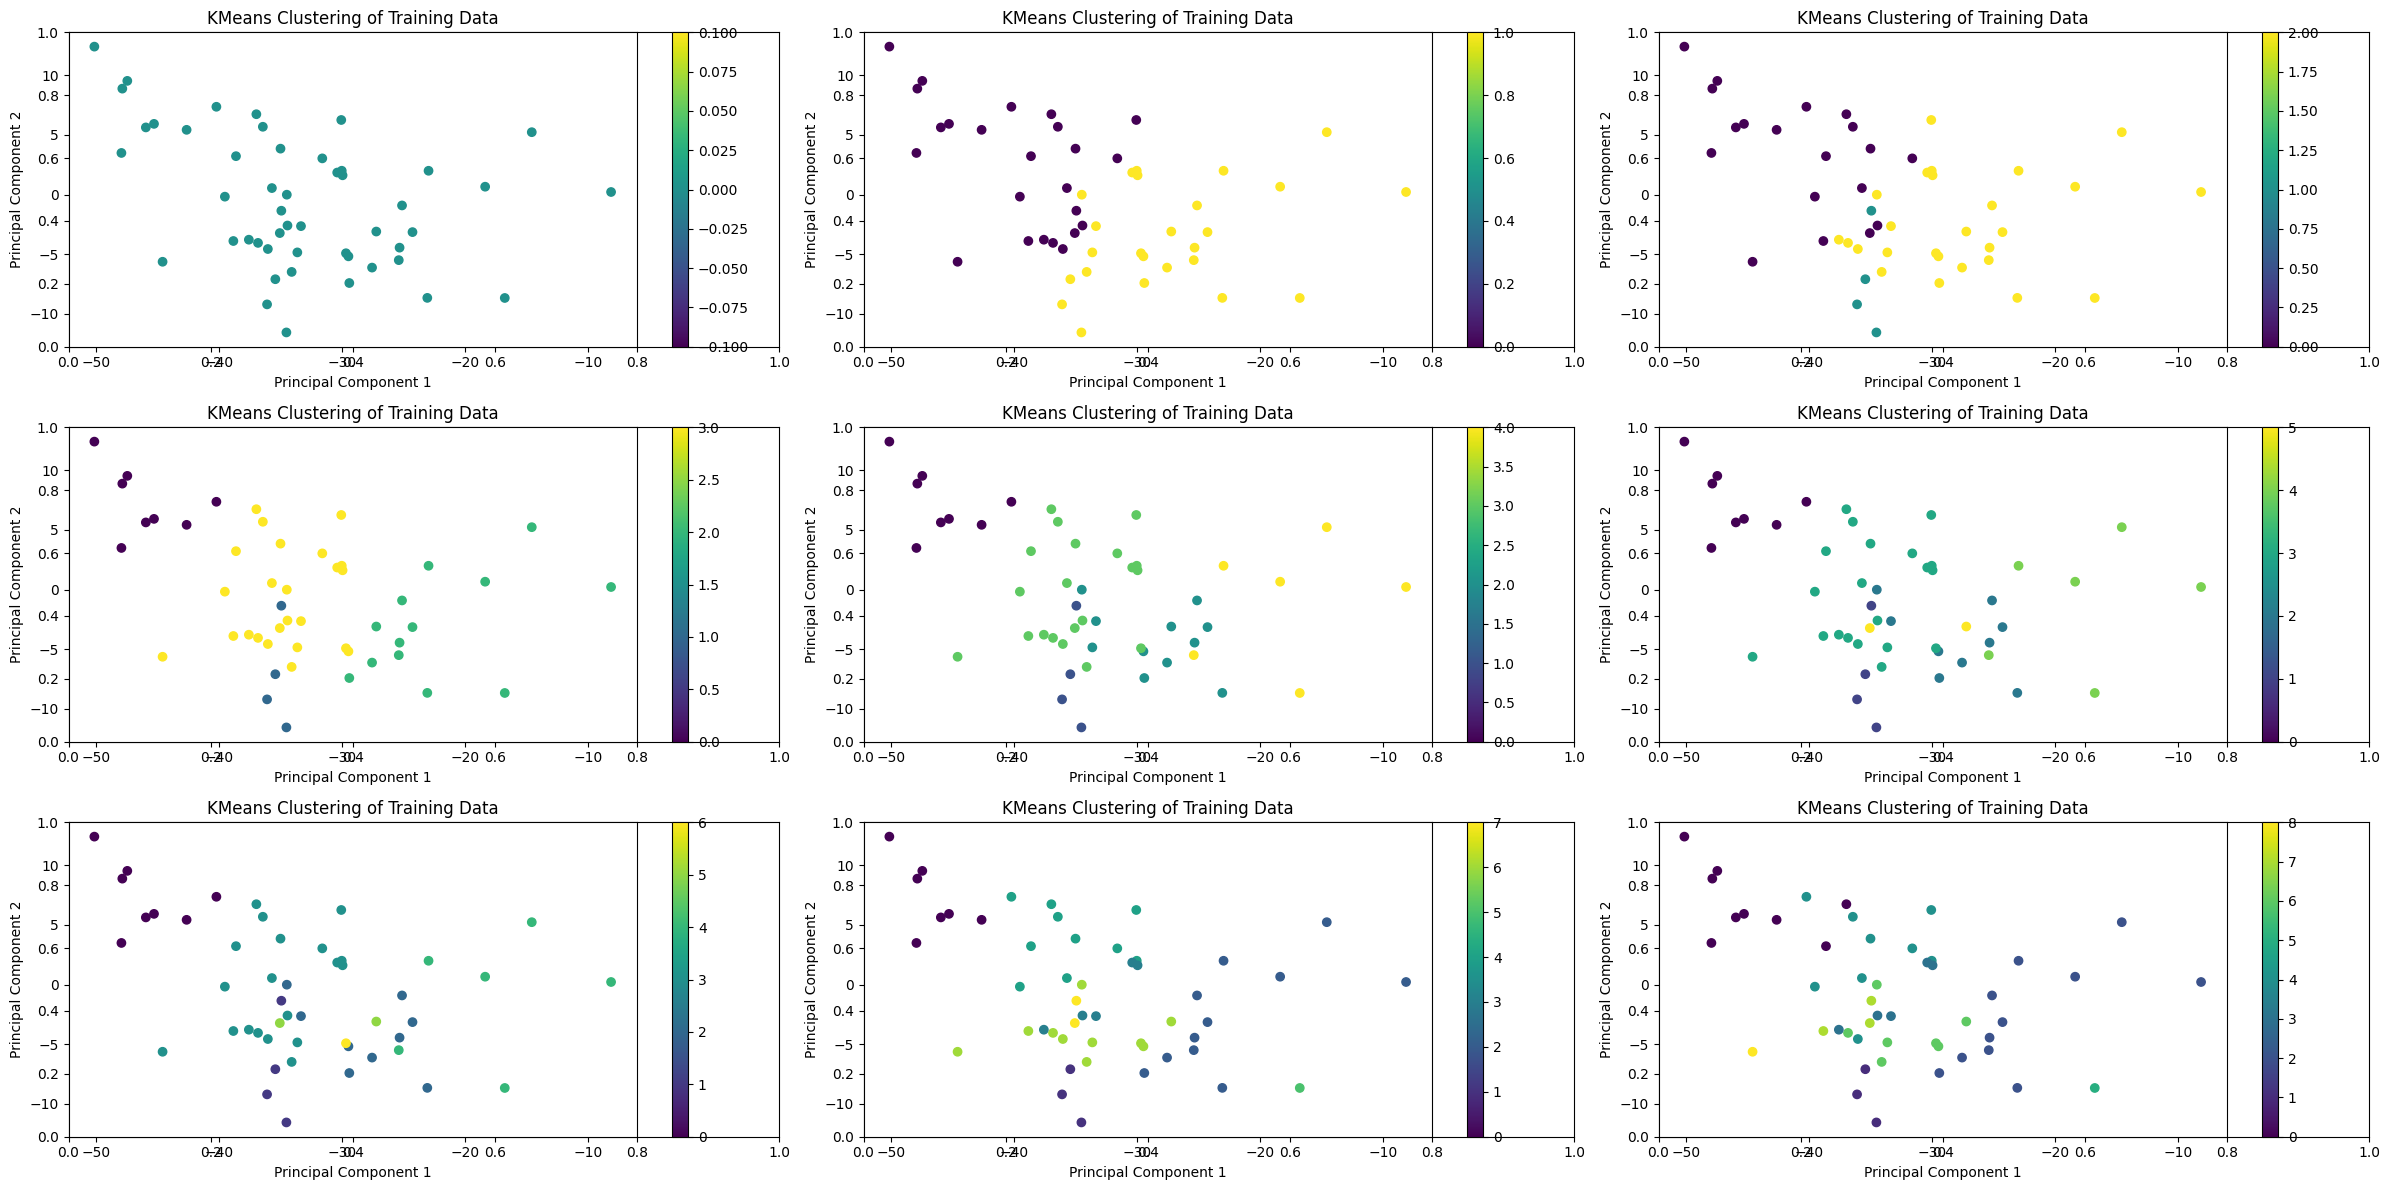

In [ ]:
from sklearn.cluster import KMeans



# we will cluster the total training set: 


data = train_dataset_full
k = 2

#lets perform PCA on the data for easier representation
U, S, V_T = np.linalg.svd(data, full_matrices=False)
U_k = U[:, :k]
S_k = np.diag(S[:k])
V_T_k = V_T[:k, :]

xtrain_reduced = data @ V_T_k.T

data_x = data[:, selected_indices]
data_y = data[:, complement_indices]

fig, ax = plt.subplots(3, 3, figsize=(24, 12))
ax = ax.flatten()
num_clusters_list = np.arange(1, 10)
i = 0
for num_clusters in num_clusters_list:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(data)

    #plot the data clustered

    ax[i] = fig.add_subplot(3, 3, num_clusters)
    ax[i].scatter(xtrain_reduced[:, 0], xtrain_reduced[:, 1], c=kmeans.labels_)
    ax[i].set_xlabel('Principal Component 1')
    ax[i].set_ylabel('Principal Component 2')
    ax[i].set_title('KMeans Clustering of Training Data')
    fig.colorbar(ax[i].collections[0], ax=ax[i])

    i += 1
plt.tight_layout()
plt.show()


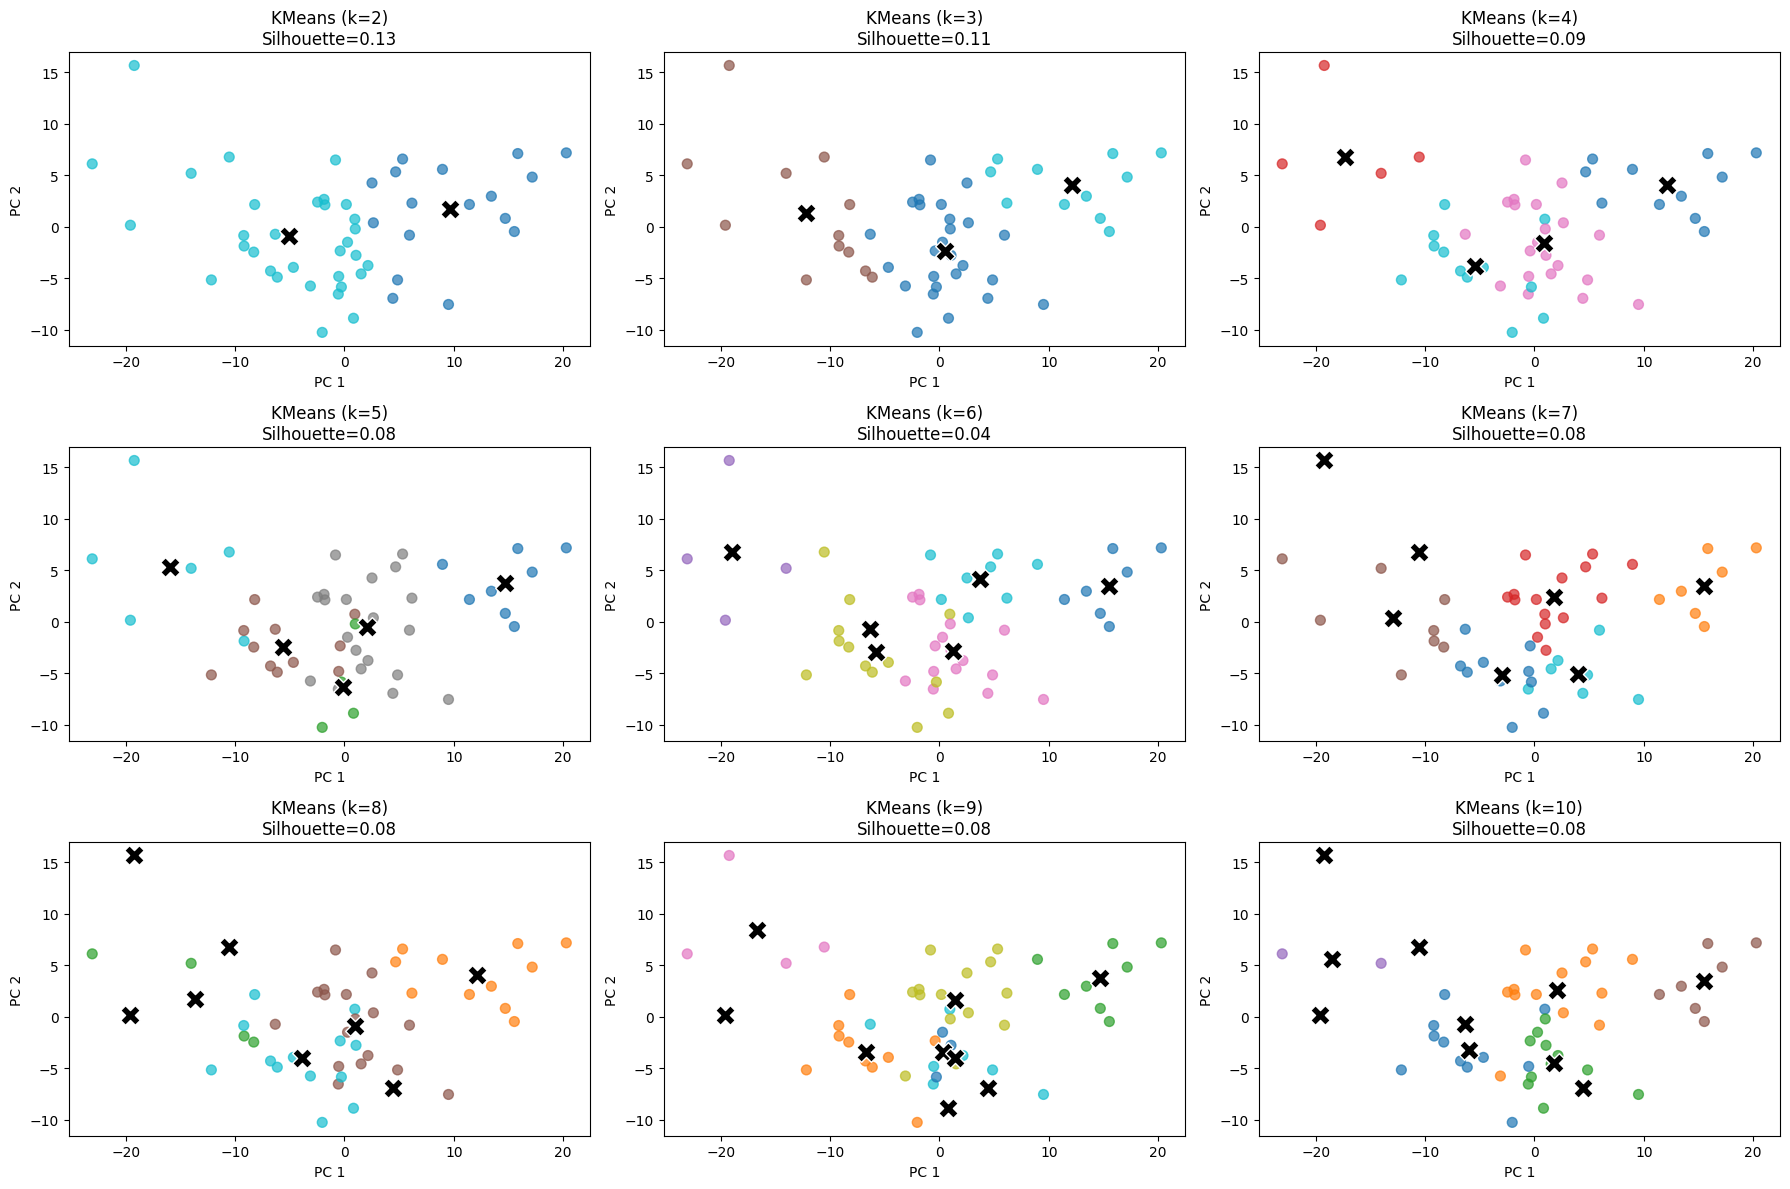

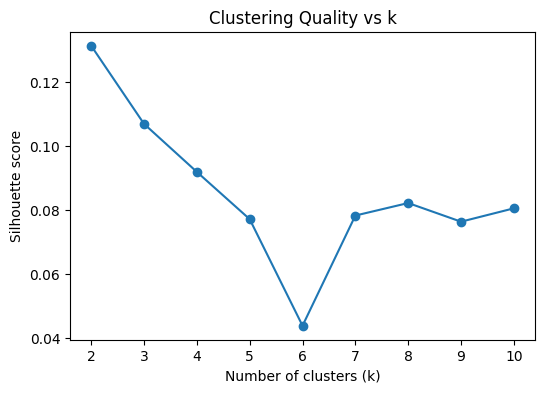

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import numpy as np

# your dataset
data = train_dataset_full  

# separate features if needed
data_x = data[:, selected_indices]
data_y = data[:, complement_indices]

# reduce to 2D for visualization with PCA
pca = PCA(n_components=2, random_state=42)
xtrain_reduced = pca.fit_transform(data)

# create subplot grid
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()

num_clusters_list = np.arange(2, 11)  # try k=2..10
silhouette_scores = []

for i, num_clusters in enumerate(num_clusters_list):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(data)

    # optional silhouette score
    score = silhouette_score(data, labels)
    silhouette_scores.append(score)

    # plot clustering in reduced PCA space
    axes[i].scatter(xtrain_reduced[:, 0], xtrain_reduced[:, 1], 
                    c=labels, cmap="tab10", alpha=0.7, s=50)

    # plot cluster centers
    centers_reduced = pca.transform(kmeans.cluster_centers_)
    axes[i].scatter(centers_reduced[:, 0], centers_reduced[:, 1], 
                    c="black", s=200, marker="X", edgecolor="white")

    axes[i].set_title(f"KMeans (k={num_clusters})\nSilhouette={score:.2f}")
    axes[i].set_xlabel("PC 1")
    axes[i].set_ylabel("PC 2")

# remove unused subplot if num_clusters_list < 9
for j in range(len(num_clusters_list), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# plot silhouette scores separately
plt.figure(figsize=(6,4))
plt.plot(num_clusters_list, silhouette_scores, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score")
plt.title("Clustering Quality vs k")
plt.show()


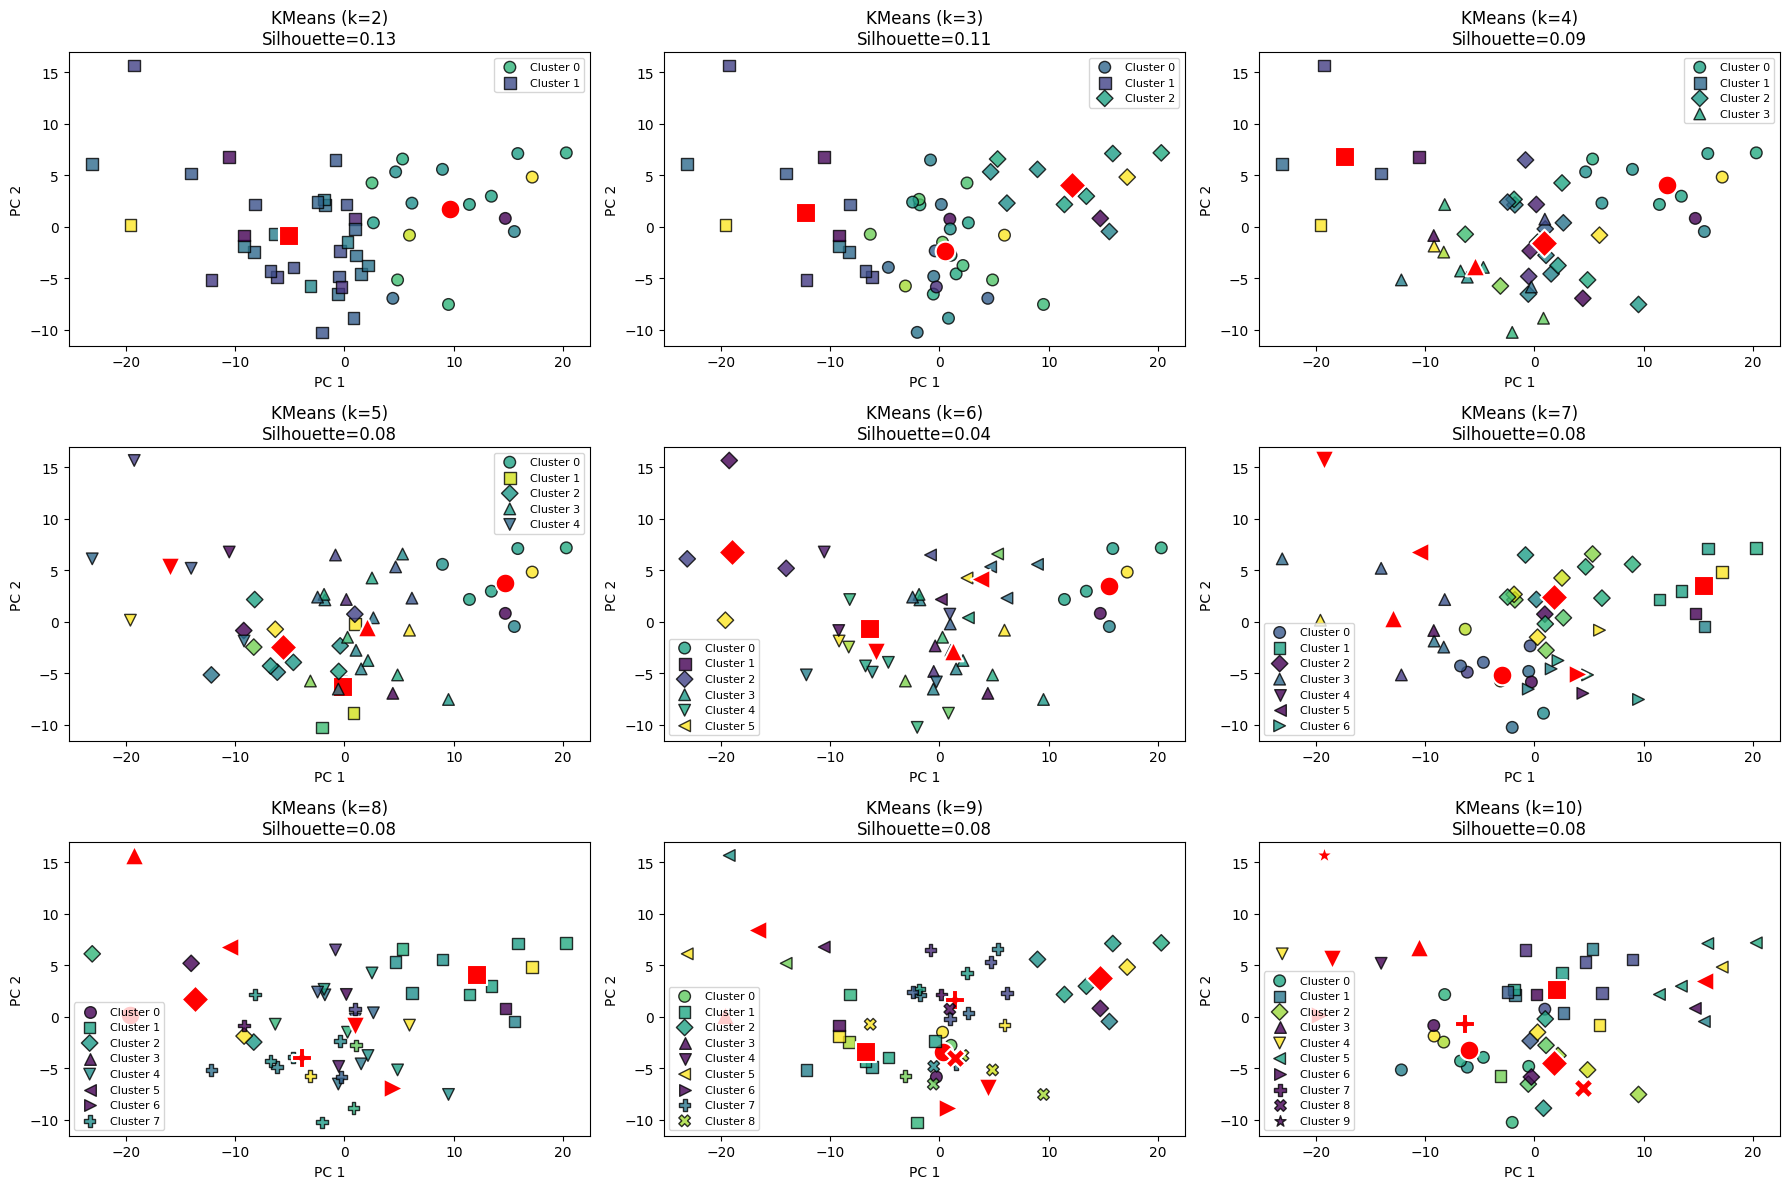

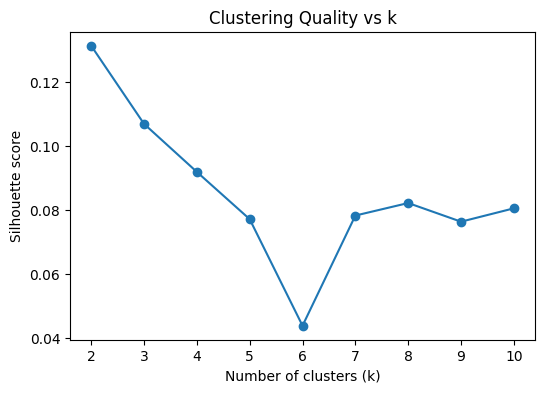

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import numpy as np

# your dataset
data = train_dataset_full  

# reduce to 3D with PCA
pca = PCA(n_components=3, random_state=42)
xtrain_reduced = pca.fit_transform(data)

# subplot grid
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()

num_clusters_list = np.arange(2, 11)  # try k=2..10
silhouette_scores = []

# define marker shapes for up to 10 clusters
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'P', 'X', '*']

for i, num_clusters in enumerate(num_clusters_list):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(data)

    score = silhouette_score(data, labels)
    silhouette_scores.append(score)

    # transform cluster centers into PCA-reduced space
    centers_reduced = pca.transform(kmeans.cluster_centers_)

    # plot scatter in 2D with color for 3rd component
    for cluster_id in np.unique(labels):
        mask = labels == cluster_id
        marker = markers[cluster_id % len(markers)]

        # plot datapoints
        axes[i].scatter(
            xtrain_reduced[mask, 0],    # PC1
            xtrain_reduced[mask, 1],    # PC2
            c=xtrain_reduced[mask, 2],  # PC3 as colormap
            cmap="viridis",
            marker=marker,
            s=70,
            edgecolor="k",
            alpha=0.8,
            label=f"Cluster {cluster_id}"
        )

        # plot cluster center
        axes[i].scatter(
            centers_reduced[cluster_id, 0],
            centers_reduced[cluster_id, 1],
            c="red",
            marker=marker,
            s=200,
            edgecolor="white",
            linewidth=1.5
        )

    axes[i].set_title(f"KMeans (k={num_clusters})\nSilhouette={score:.2f}")
    axes[i].set_xlabel("PC 1")
    axes[i].set_ylabel("PC 2")
    axes[i].legend(fontsize=8, loc="best")

# remove unused subplot if < 9
for j in range(len(num_clusters_list), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# plot silhouette scores
plt.figure(figsize=(6,4))
plt.plot(num_clusters_list, silhouette_scores, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score")
plt.title("Clustering Quality vs k")
plt.show()



In [ ]:
""" Fine-tuning the NN Model after coarse grid search"""

def my_gridsearch(data, selected_indices, complement_indices, n_deep_layers, nodes_per_layer_options, k_options, batch_size_options, num_epochs_options, n_splits=5):

    best_model = None
    best_val_error = float("inf")
    all_results = pd.read_csv("fine_tune_grid_search_results.csv")
    new_results = []
    for n_deep_layer in n_deep_layers:
        for nodes_per_layer in nodes_per_layer_options:
            for k in k_options:
                for batch_size in batch_size_options:
                    for num_epochs in num_epochs_options:

                        print(f"Training with n_deep_layers={n_deep_layer}, nodes_per_layer={nodes_per_layer}, k={k}, batch_size={batch_size}, num_epochs={num_epochs}")

                        models, rel_errors_train, rel_errors_val, loss_train, loss_val, avg_train_error, avg_val_error, avg_loss_train, avg_loss_val = cross_validate_model(
                            data, selected_indices, complement_indices, n_deep_layer, nodes_per_layer=nodes_per_layer, k=k, batch_size=batch_size, num_epochs=num_epochs, n_splits=n_splits
                        )

                        new_results.append({
                            "n_deep_layers": n_deep_layer,
                            "nodes_per_layer": nodes_per_layer,
                            "k": k,
                            "batch_size": batch_size,
                            "num_epochs": num_epochs,
                            "avg_train_error": avg_train_error,
                            "avg_val_error": avg_val_error
                        })
                        pd.DataFrame([new_results[-1]]).to_csv("fine_tune_grid_search_results.csv", mode='a', index=False, header=False)
                        print("Finished one cross-validation run")
                        if avg_val_error < best_val_error:
                            best_val_error = avg_val_error
                            best_model = models

    return best_model, all_results

# perform grid search
data = train_dataset_full
n_deep_layers = [3, 4, 5]
best_model, all_results = my_gridsearch(
    data, selected_indices, complement_indices, n_deep_layers,
    nodes_per_layer_options=[64],
    k_options=[1,2,3,4],
    batch_size_options=[8],
    num_epochs_options=[50],
    n_splits=5
)
best_results = [4,16,3,8,50,0.390937378574003,0.41986437579647556]
print(f'best params: n_deep_layers={best_results[0]}, nodes_per_layer={best_results[1]}, k={best_results[2]}, batch_size={best_results[3]}, num_epochs={best_results[4]} \n best train error: {best_results[5]}, best val error: {best_results[6]}')




Training with n_deep_layers=3, nodes_per_layer=64, k=1, batch_size=8, num_epochs=50
Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2987 - mae: 0.4637  
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2730 - mae: 0.4449 
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2322 - mae: 0.4029 
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2079 - mae: 0.3742 
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1657 - mae: 0.3388
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1190 - mae: 0.2799 
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0888 - mae: 0.2440 
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0815 - mae: 0.2328 
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0622 - mae: 0.2004 
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0633 - mae: 0.2045 
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0607 - mae: 0.2003 
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss

In [18]:
best_results = [4,16,3,8,50,0.390937378574003,0.41986437579647556]
print(f'best params: n_deep_layers={best_results[0]}, nodes_per_layer={best_results[1]}, k={best_results[2]}, batch_size={best_results[3]}, num_epochs={best_results[4]} \n best train error: {best_results[5]}, best val error: {best_results[6]}')


#now we will train and save the best model:

def save_opt_model(train_dataset_full, selected_indices, complement_indices, n_deep_layers=4, nodes_per_layer=16, k=3, batch_size=8, num_epochs=50):
    normalization_factor = 1/10 
    data = train_dataset_full * normalization_factor # Normalize the data to be between 0 and 1


    X_train, X_val = data[:], data[:]
    JTrain_x = X_train[:, selected_indices]
    JTrain_y = X_train[:, complement_indices]
    JDev_x = X_val[:, selected_indices]
    JDev_y = X_val[:, complement_indices]

    mu_x = np.mean(JTrain_x, axis=0)
    X_train_centered = JTrain_x - mu_x
    X_val_centered = JDev_x - mu_x


    U, S, V_T = np.linalg.svd(JTrain_x, full_matrices=False)
    U_k = U[:, :k]
    S_k = np.diag(S[:k])
    V_T_k = V_T[:k, :]

    xtrain_reduced = X_train_centered @ V_T_k.T
    xtrain_reduced = np.hstack((xtrain_reduced, np.ones((xtrain_reduced.shape[0], 1))))  # Add bias term
    x_dev_reduced = X_val_centered @ V_T_k.T
    x_dev_reduced = np.hstack((x_dev_reduced, np.ones((x_dev_reduced.shape[0], 1))))  # Add bias term

    layers = [keras.layers.Input(shape=(xtrain_reduced.shape[1],))]
    for i in range(n_deep_layers):
        layers.append(keras.layers.Dense(nodes_per_layer, activation="relu"))
    layers.append(keras.layers.Dense(JTrain_y.shape[1], activation="linear"))
    model = keras.Sequential(layers)
    model.compile(optimizer="adam",
                    loss="mse", metrics=["mae"])


    model.fit(
        xtrain_reduced, JTrain_y,
        epochs=num_epochs,
        batch_size=batch_size
    )

    model.save("my_NN_optimal_parameters.h5")
    print("Model saved to my_NN_optimal_parameters.h5")
    return model

optimal_NN = save_opt_model(train_dataset_full, selected_indices, complement_indices, n_deep_layers=4, nodes_per_layer=16, k=3, batch_size=8, num_epochs=50)


best params: n_deep_layers=4, nodes_per_layer=16, k=3, batch_size=8, num_epochs=50 
 best train error: 0.390937378574003, best val error: 0.41986437579647556
Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3073 - mae: 0.4774  
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2939 - mae: 0.4621 
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2621 - mae: 0.4253 
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2570 - mae: 0.4295 
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2180 - mae: 0.3871 
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1940 - mae: 0.3668 
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1879 - mae: 0.3570 
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1608 - mae: 0.3316 
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1428 - mae: 0.3117 
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1212 - mae: 0.2857 
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1

Model saved to my_NN_optimal_parameters.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
train rel error: 0.39947720649117807
test rel error: 0.434209891391857
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0510 - mae: 0.1818
training loss: 0.11585927940905094
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0673 - mae: 0.2086
test loss: 0.13798999041318893
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0510 - mae: 0.1818
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0673 - mae: 0.2086


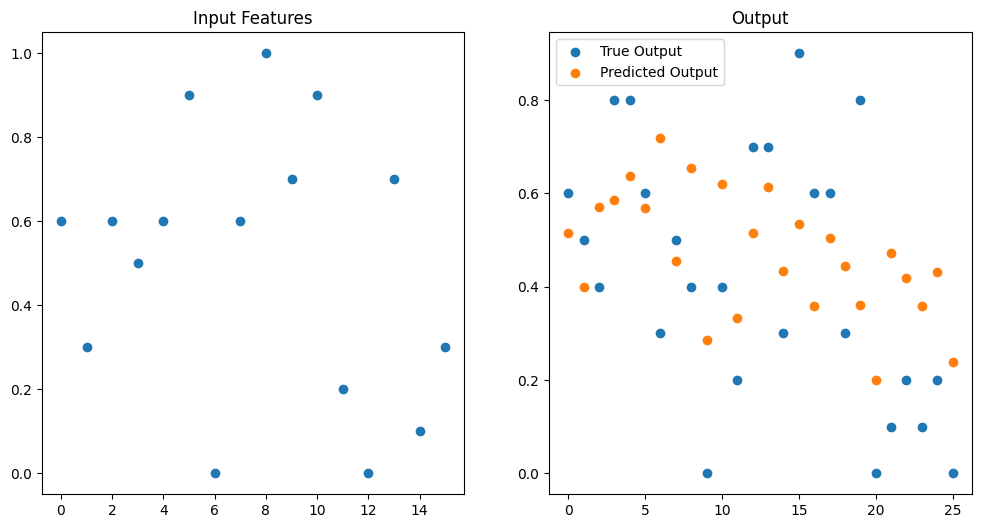

In [26]:
#create_final_model(train_dataset_full, selected_indices, complement_indices, n_deep_layers=4, nodes_per_layer=16, k=3, batch_size=8, num_epochs=50)


"""Now, let's evaluate the final model and visualize some of the results"""
normalization_factor = 1/10
xtest = test_dataset[:, selected_indices] *normalization_factor
ytest = test_dataset[:, complement_indices] *normalization_factor

xtrain = train_dataset_full[:, selected_indices] * normalization_factor
ytrain = train_dataset_full[:, complement_indices] * normalization_factor

mu_x = np.mean(xtrain, axis=0)
xtrain_centered = xtrain - mu_x
xtest_centered = xtest - mu_x

k=3 #optimim PCA value


U, S, V_T = np.linalg.svd(xtrain_centered, full_matrices=False)
U_k = U[:, :k]
S_k = np.diag(S[:k])
V_T_k = V_T[:k, :]

xtrain_reduced = xtrain_centered @ V_T_k.T
xtrain_reduced = np.hstack((xtrain_reduced, np.ones((xtrain_reduced.shape[0], 1))))  # Add bias term
xtest_reduced = xtest_centered @ V_T_k.T
xtest_reduced = np.hstack((xtest_reduced, np.ones((xtest_reduced.shape[0], 1))))  # Add bias term

ytrain_predicted = optimal_NN.predict(xtrain_reduced)
ytest_predicted = optimal_NN.predict(xtest_reduced)

print(f'train rel error: {np.linalg.norm(ytrain_predicted - ytrain, "fro") / np.linalg.norm(ytrain, "fro")}')
print(f'test rel error: {np.linalg.norm(ytest_predicted - ytest, "fro") / np.linalg.norm(ytest, "fro")}')
print(f'training loss: {np.mean(optimal_NN.evaluate(xtrain_reduced, ytrain))}')
print(f'test loss: {np.mean(optimal_NN.evaluate(xtest_reduced, ytest))}')

# let's store the results
all_relative_errors_training.append(np.linalg.norm(ytrain_predicted - ytrain, "fro") / np.linalg.norm(ytrain, "fro"))
all_relative_errors_validation.append(np.linalg.norm(ytest_predicted - ytest, "fro") / np.linalg.norm(ytest, "fro"))
all_loss_training.append(np.mean(optimal_NN.evaluate(xtrain_reduced, ytrain)))
all_loss_validation.append(np.mean(optimal_NN.evaluate(xtest_reduced, ytest)))

# now let's take a random surveyee in the test set and visualize the results
random_index = np.random.randint(0, xtest.shape[0])
x_random = xtest[random_index]
y_random = ytest[random_index]
y_random_predicted = ytest_predicted[random_index]

# plot the results
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].set_title('Input Features')
ax[0].scatter(range(len(x_random)), x_random)
ax[1].set_title('Output')
ax[1].scatter(range(len(y_random)), y_random, label='True Output')
ax[1].scatter(range(len(y_random_predicted)), y_random_predicted, label='Predicted Output')
ax[1].legend()
plt.show()